In [363]:
## Import Libraries

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import xgboost as xgb 
from xgboost import XGBClassifier
from sklearn import preprocessing
#import seaborn as sns
#sns.set(style = "whitegrid", color_codes = True)
os.chdir('D:/Study/Python Programs/DDT Interview Practice/')

In [151]:
## Data Preprocessing

# read data
data = pd.read_csv('speeddating.csv')

# rename colunns
data = data.rename(columns={'ambition':'ambitious', "ambitous_o":"ambitious_o", 'sinsere_o':'sincere_o', 'intellicence_important':'intelligence_important', 'ambtition_important':'ambitious_important', 'ambition_partner':'ambitious_partner','d_sinsere_o':'d_sincere_o', 'd_ambitous_o':'d_ambitious_o', 'd_intellicence_important':'d_intelligence_important', 'd_ambtition_important':'d_ambitious_important', 'd_ambition':'d_ambitious', 'd_ambition_partner':'d_ambitious_partner'})

data = data.replace('?', 0)

In [165]:
## Extract Interest Data
interests = ['sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']
interest_data = data[interests]
# data = data.drop(interests, axis=1)

In [16]:
def SplitAgeRange(age_range):
    age1, age2 = age_range[1:-1].split('-')
    return int(age1), int(age2)


In [152]:
data['samerace'] = data['samerace'] == 0

In [439]:
# Split Data by Rating Targets
features = ['attractive','sincere','intelligence','funny','ambitious', 'shared_interests']
own_feature_data = data[features[:-1]] # rate themselves
partner_rating_data = data[[f'{f}_o' for f in features]] # rated by partner
feature_importance_data = data[[f'{f}_important' for f in features]] # ideal partner
partner_feature_data = data[[f'{f}_partner' for f in features]] # rate partner

In [466]:
# Split Data by Feature Types

#attractive
attractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)
attractive_data = attractive_data[(attractive_data != 0).all(1)]
#sincere
sincere_data = data[['sincere', 'sincere_o', 'sincere_partner']].astype(float)
sincere_data = sincere_data[(sincere_data != 0).all(1)]
#intelligence
intelligence_data = data[['intelligence', 'intelligence_o', 'intelligence_partner']].astype(float)
intelligence_data = intelligence_data[(intelligence_data != 0).all(1)]

"""
attractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)
attractive_data = attractive_data[(attractive_data != 0).all(1)]

attractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)
attractive_data = attractive_data[(attractive_data != 0).all(1)]

attractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)
attractive_data = attractive_data[(attractive_data != 0).all(1)]
"""

"\nattractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)\nattractive_data = attractive_data[(attractive_data != 0).all(1)]\n\nattractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)\nattractive_data = attractive_data[(attractive_data != 0).all(1)]\n\nattractive_data = data[['attractive', 'attractive_o', 'attractive_partner']].astype(float)\nattractive_data = attractive_data[(attractive_data != 0).all(1)]\n"

"\nMin_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) # 設定縮放的區間上下限\nnew_data = Min_Max_Scaler.fit_transform(attractive_data) # Data 為原始資料\n\nnew_data = pd.DataFrame(data = new_data, columns = ['attractive', 'attractive_o', 'attractive_important', 'attractive_partner'])\nnew_data.boxplot()\n"

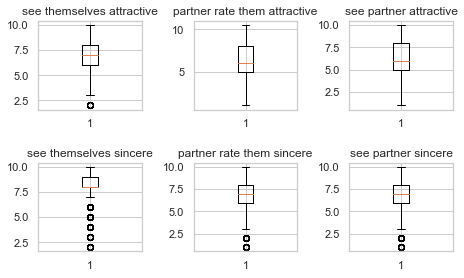

In [467]:
#print(attractive_data['attractive'].astype(float).mean())
#print(attractive_data['attractive_o'].astype(float).mean())
#print(attractive_data['attractive_partner'].astype(float).mean())

#attractive_data.astype(float).boxplot()
fig, axs = plt.subplots(2,3)
#-attractive
axs[0,0].boxplot(attractive_data['attractive'])
axs[0,0].set_title('see themselves attractive')

axs[0,1].boxplot(attractive_data['attractive_o'])
axs[0,1].set_title('partner rate them attractive')

axs[0,2].boxplot(attractive_data['attractive_partner'])
axs[0,2].set_title('see partner attractive')
#-sincere
axs[1,0].boxplot(sincere_data['sincere'])
axs[1,0].set_title('see themselves sincere')

axs[1,1].boxplot(sincere_data['sincere_o'])
axs[1,1].set_title('partner rate them sincere')

axs[1,2].boxplot(sincere_data['sincere_partner'])
axs[1,2].set_title('see partner sincere')

fig.subplots_adjust(left = 0.02, right = 0.98, bottom = 0.1, top = 0.9, hspace = 0.6, wspace = 0.5)
"""
Min_Max_Scaler = preprocessing.MinMaxScaler( feature_range=(0,1) ) # 設定縮放的區間上下限
new_data = Min_Max_Scaler.fit_transform(attractive_data) # Data 為原始資料

new_data = pd.DataFrame(data = new_data, columns = ['attractive', 'attractive_o', 'attractive_important', 'attractive_partner'])
new_data.boxplot()
"""

In [155]:
# create clean_data table for xgboost model
clean_data = data.drop(['d_expected_num_interested_in_me', 'd_expected_num_matches', 'd_like', 'd_guess_prob_liked', 'd_expected_happy_with_sd_people', 'd_interests_correlate', 'd_d_age', 'd_importance_same_religion', 'd_importance_same_race'], axis=1)
clean_data = clean_data.drop([f'd_pref_o_{f}' for f in features], axis=1)
clean_data = clean_data.drop([f'd_{f}_o' for f in features], axis=1)
clean_data = clean_data.drop([f'd_{f}_important' for f in features], axis=1)
clean_data = clean_data.drop([f'd_{f}' for f in features[:-1]], axis=1)
clean_data = clean_data.drop([f'd_{f}_partner' for f in features], axis = 1)
clean_data = clean_data.drop([f'd_{i}' for i in interests], axis = 1)
clean_data = clean_data.replace('?', 0)
clean_data['user'] = clean_data.groupby(features[:-1]).grouper.group_info[0] + 1

In [139]:
matched_cor = clean_data[['user', 'interests_correlate']].astype(float)[clean_data['match'] == 0].groupby('user').mean()

In [140]:
total_cor = clean_data[['user', 'interests_correlate']].astype(float).groupby('user').mean()

In [141]:
(total_cor.mean() - matched_cor.mean()) / np.std(clean_data['interests_correlate'].astype(float))

interests_correlate    0.01051
dtype: float64

In [137]:
np.std(clean_data['interests_correlate'].astype(float))


0.301825070428497

In [321]:
# selected parameters, drop parameters (including drop_fileds and not_suitables)
param = {'booster':'gblinear', 'lambda':1, 'alpha':0, 'subsample':1, 'predictor':'cpu_predictor', 'max_depth':20}
drop_fields = ['match', 'race', 'race_o', 'gender', 'field', 'decision', 'decision_o', 'like', 'guess_prob_liked', 'has_null', 'wave', 'user']
not_suitables = ['shopping', 'tv', 'shared_interests_o', 'attractive_o']

drop_fields.extend(not_suitables)
#drop_fields.extend(clean_data.columns[5:])


accuracy_1 = 0
accuracy_0 = 0
model_features = []

ac0 = 0
for i in range(10):
    testing = clean_data.sample(frac=1/5)
    training = clean_data[(~clean_data.isin(testing))].dropna() 
    
    for _ in range(5):
        #testing = testing.append(testing[testing['match'] == 1])
        training = training.append(training[training['match'] == 1])

    model = XGBClassifier()
    model.fit(training.drop(drop_fields, axis=1).astype(float), training['match'].astype(float))

    ypred = model.predict(testing.drop(drop_fields, axis=1).astype(float))

    #ac1 = sum(ypred == testing['match']) / testing.shape[0]
    ac1 = sum((ypred == testing['match'])[testing['match'] == 1]) / testing[testing['match'] == 1].shape[0]
    ac0 = sum((ypred == testing['match'])[testing['match'] == 0]) / testing[testing['match'] == 0].shape[0]
    print(ac1, ac0)

    model_features.append(model.feature_importances_)
    accuracy_1 += ac1
    accuracy_0 += ac0

print(f'Average 1: {accuracy_1 / 10}')
print(f'Average 0: {accuracy_0 / 10}')
print((accuracy_0 + accuracy_1)/ 20)
# dTrain = xgb.DMatrix(own_feature_data.astype(float), label=clean_data['match'].astype(float))
# bst = xgb.train(param, dTrain) #, xgb_model=bst)  # for retraining
# bst.save_model('./xgb_model.model')


0.5851063829787234 0.8637015781922525
0.6336996336996337 0.8289379900213828
0.6093189964157706 0.8596993557623479
0.5724381625441696 0.8513998564249821
0.6181818181818182 0.8443968593861527
0.6501901140684411 0.8485491861288039
0.6173285198555957 0.8413152251608291
0.61 0.842296511627907
0.6216216216216216 0.8546224417784051
0.6046511627906976 0.8561354019746121
Average 1: 0.6122536412156473
Average 0: 0.8491054406457677
0.7306795409307074


In [314]:
print([np.mean(n) for n in np.array(model_features).swapaxes(0,1)] * np.array(1))
print([np.std(n) / np.mean(n)for n in np.array(model_features).swapaxes(0,1)] * np.array(len(model.feature_importances_)))

[0.01616631 0.01333578 0.01736134 0.0107634  0.01751595 0.01488729
 0.01408346 0.01387095 0.01492594 0.01329799 0.01297218 0.01489345
 0.04365777 0.01425968 0.01908018 0.04928171 0.01042519 0.01802812
 0.0180738  0.02075329 0.01625402 0.01538573 0.01683544 0.01748611
 0.01620658 0.01536471 0.01582676 0.01414919 0.04570573 0.01375203
 0.01913344 0.05582486 0.01099286 0.02580451 0.02082609 0.01659332
 0.02315671 0.01496567 0.01158459 0.01503426 0.01558558 0.01607865
 0.01945235 0.02020182 0.01656794 0.01604246 0.01679646 0.01430782
 0.01484863 0.01323331 0.01621428 0.01337789 0.02142646 0.01734995]
[ 9.286774   5.8692393  6.9905853 11.727707   9.4871     7.709748
  6.091811   9.007259   5.6088047  6.752616   5.4375196  5.941324
  3.7144172  6.846575  10.558932   8.337529   5.3994584  7.9620137
  7.0540757  8.849855   4.423619   7.0506     6.7175264 16.10665
 10.818235  13.745163  16.996078  11.2254095  4.6625285  7.8044767
 12.057793  10.7708645  8.359395   4.9938006 12.495643   7.203298

In [320]:
clean_data.drop(drop_fields, axis=1).columns[12]

'attractive_o'

In [ ]:
sum(clean_data['match'] == 0)

In [308]:
testing.shape

(1676, 69)